## Quick analysis of Sexome data for WCH9!

In [1]:
import vcf
import sys

### Quick sex linked marker finder

Find markers het in males and hom in females

In [2]:
def male_bias_calculator(vcf_path, popmap_path):

    import vcf
    
    ## read vcf
    
    myvcf = vcf.Reader(open(vcf_path, 'r'))
    
    ## Get popmap info
    
    popmap = open(popmap_path, 'r').readlines()

    males = []
    females = []

    for line in popmap:
        name = line.split()[0]
        sex = line.split()[1]

        if sex == "M":
            males.append(name)
        elif sex == "F":
            females.append(name)
    
    male_bias_output = {}
    
    for record in myvcf:
    
        N_males_called = 0
        N_females_called = 0

        N_het_males = 0
        N_het_females = 0

        for sample in record.samples:
            #print(sample.sample)

            if sample.called:
                if sample.sample in males:
                    N_males_called += 1
                    if sample.is_het:
                        N_het_males += 1

                elif sample.sample in females:
                    N_females_called += 1
                    if sample.is_het:
                        N_het_females += 1

        if N_males_called == 0:
            Male_call_rate = 0
        else:
            Male_call_rate = N_males_called/len(males)

        if N_het_males == 0:
            male_heterozygosity = 0
        else:
            male_heterozygosity = N_het_males / N_males_called

        if N_females_called == 0:
            Female_call_rate = 0
        else:
            Female_call_rate = N_females_called/len(females)

        if N_het_females == 0:
            female_heterozygosity = 0
        else:
            female_heterozygosity = N_het_females / N_females_called 
        
        male_bias = male_heterozygosity - female_heterozygosity
        
        if record.CHROM not in male_bias_output:
            male_bias_output[record.CHROM] = {}
            male_bias_output[record.CHROM]["POS"] = []
            male_bias_output[record.CHROM]["male_bias"] = []
            
        male_bias_output[record.CHROM]["POS"].append(int(record.POS))
        male_bias_output[record.CHROM]["male_bias"].append(male_bias)
        
    return male_bias_output
        
        


In [15]:
male_biases = male_bias_calculator("/Users/danieljeffries/Desktop/Sexome/Subset_VCFs/RIBE_MinDP_20_MaxMiss_08.recode.vcf", 
                    "/Users/danieljeffries/Desktop/Sexome/popmaps/popmap_RIBE.txt")

In [36]:
from matplotlib import pyplot as plt
import numpy as np

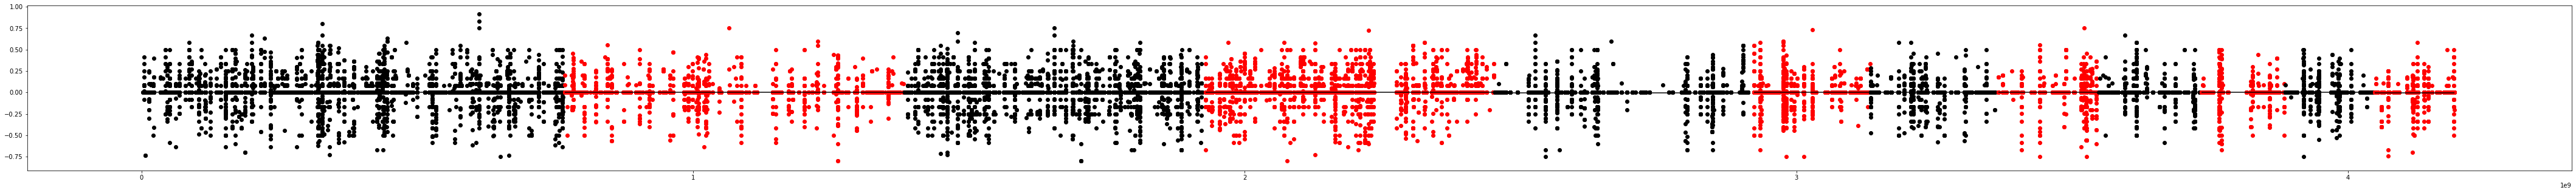

In [48]:
plt.figure(figsize = (75,5))

xcoord = 0
col = "black"

for i in range(1,13,1):
    
    xs = [x+xcoord for x in male_biases["chr%s" % i]["POS"]]
    
    plt.scatter(xs, male_biases["chr%s" % i]["male_bias"], c = col)
    plt.hlines(np.mean(male_biases["chr%s" % i]["male_bias"]), min(xs), max(xs))

    xcoord += max(male_biases["chr%s" % i]["POS"])
    
    if col == "red":
        col = "black"
    elif col == "black":
        col = "red"
    

### What do the quality scores look like?

In [105]:
import vcf
    
## read vcf
vcf_path = "/Users/danieljeffries/Desktop/Sexome/Subset_VCFs/RIBE_MinDP_20_MaxMiss_08.recode 2.vcf"
myvcf = vcf.Reader(open(vcf_path, 'r'))

record = next(myvcf)


In [84]:
quals = []
for record in myvcf:
    for sample in record.samples:
        if sample["GQ"] == None:
            sample_GQ = 0
        else:
            sample_GQ = sample["GQ"]
        
        quals.append(sample_GQ)

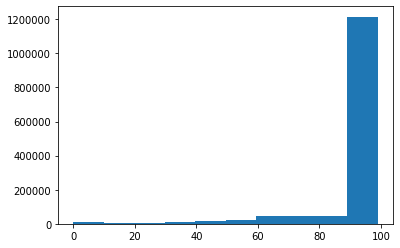

In [87]:
plt.hist(quals, bins=10, )
plt.show()

So I think they look good! 

### What proportion of the variants are SNPs and what proportion are INDELS?

In [98]:
len(record.REF)

1

In [ ]:
myvcf = vcf.Reader(open(vcf_path, 'r'))

indels = 0
snps = 0

INDEL_lengths = []

for record in myvcf:
    if record.is_indel:
        indels += 1
        
        INDEL_lengths.append(len(record.REF))
        
    elif record.is_snp:
        snps += 1


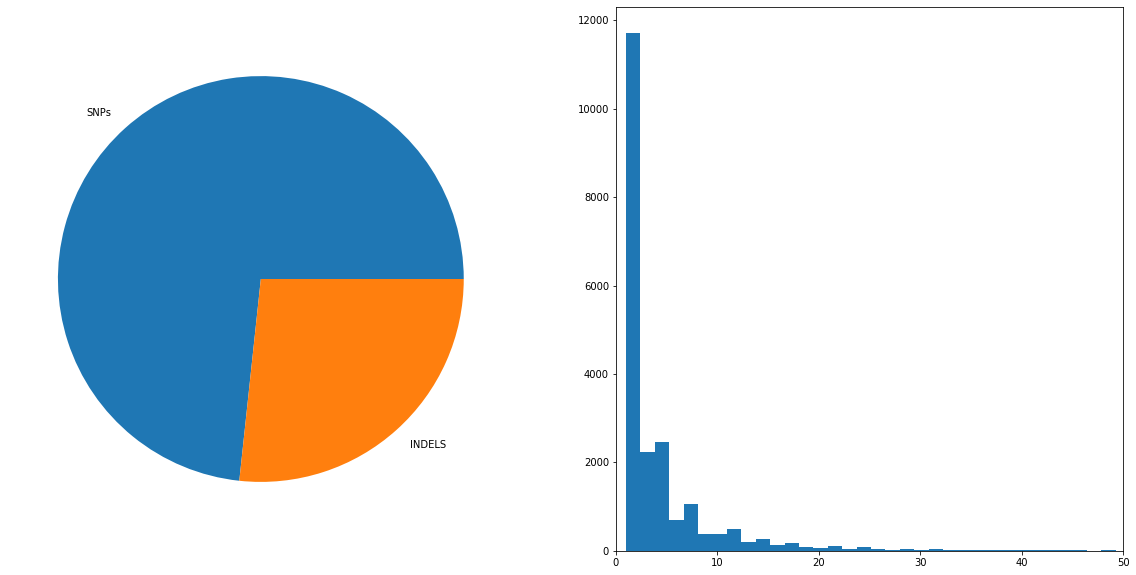

In [102]:

plt.figure(figsize = (20,10))
plt.subplot(121)
plt.pie([snps, indels], labels=["SNPs", "INDELS"])

plt.subplot(122)
plt.hist(INDEL_lengths, bins = 200)
plt.xlim(0,50)
plt.show()

Ok, cool, that solves that one. Just over a quarter of the variants are INDELS. Most of which are small, but some can be quite large actually. 

What next? Coverage?

In [107]:
myvcf = vcf.Reader(open(vcf_path, 'r'))

COVS = []

for record in myvcf:
    for sample in record.samples:
        COVS.append(sample["DP"])


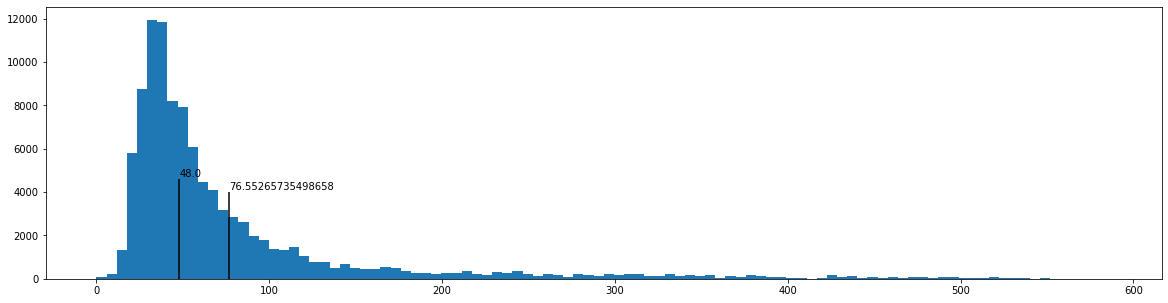

In [130]:

plt.figure(figsize = (20,5))
plt.hist(COVS, bins = 100)
plt.vlines(np.mean(COVS), 0, 4000)
plt.text(np.round(float(np.mean(COVS))), 4100, np.mean(COVS))
plt.vlines(np.median(COVS), 0, 4600)
plt.text(np.round(float(np.median(COVS))), 4700, np.median(COVS))

plt.show()

So coverage isnt super high, but it will be fine. 

And lets have a look at the population structure in the data . . . 